# **Classification**

## _Classifying Fisher's Iris data using the C4.5 decision tree model._


Importing the necessary libraries :





In [1]:
from math import log
import operator
import treePlotter as tpl
from sklearn.datasets import load_iris

Function to load the Iris dataset :


In [2]:
def createDataSet():
    iris = load_iris()

    # Convert numerical target values to corresponding class names
    target_names = iris.target_names.tolist()
    labels = [target_names[int(label)] for label in iris.target]

    # Combine features and labels
    iris_data = [row + [label] for row, label in zip(iris.data.tolist(), labels)]

    return iris_data, iris.feature_names + ['species']

Displaying the loaded Iris dataset :


In [3]:
iris_data, iris_labels = createDataSet()
print(iris_data)

[[5.1, 3.5, 1.4, 0.2, 'setosa'], [4.9, 3.0, 1.4, 0.2, 'setosa'], [4.7, 3.2, 1.3, 0.2, 'setosa'], [4.6, 3.1, 1.5, 0.2, 'setosa'], [5.0, 3.6, 1.4, 0.2, 'setosa'], [5.4, 3.9, 1.7, 0.4, 'setosa'], [4.6, 3.4, 1.4, 0.3, 'setosa'], [5.0, 3.4, 1.5, 0.2, 'setosa'], [4.4, 2.9, 1.4, 0.2, 'setosa'], [4.9, 3.1, 1.5, 0.1, 'setosa'], [5.4, 3.7, 1.5, 0.2, 'setosa'], [4.8, 3.4, 1.6, 0.2, 'setosa'], [4.8, 3.0, 1.4, 0.1, 'setosa'], [4.3, 3.0, 1.1, 0.1, 'setosa'], [5.8, 4.0, 1.2, 0.2, 'setosa'], [5.7, 4.4, 1.5, 0.4, 'setosa'], [5.4, 3.9, 1.3, 0.4, 'setosa'], [5.1, 3.5, 1.4, 0.3, 'setosa'], [5.7, 3.8, 1.7, 0.3, 'setosa'], [5.1, 3.8, 1.5, 0.3, 'setosa'], [5.4, 3.4, 1.7, 0.2, 'setosa'], [5.1, 3.7, 1.5, 0.4, 'setosa'], [4.6, 3.6, 1.0, 0.2, 'setosa'], [5.1, 3.3, 1.7, 0.5, 'setosa'], [4.8, 3.4, 1.9, 0.2, 'setosa'], [5.0, 3.0, 1.6, 0.2, 'setosa'], [5.0, 3.4, 1.6, 0.4, 'setosa'], [5.2, 3.5, 1.5, 0.2, 'setosa'], [5.2, 3.4, 1.4, 0.2, 'setosa'], [4.7, 3.2, 1.6, 0.2, 'setosa'], [4.8, 3.1, 1.6, 0.2, 'setosa'], [5.4, 3

Function to calculate Shannon entropy :


In [4]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}

    # Count occurrences of each class label
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1

    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)

    return shannonEnt

Calculating Shannon entropy for the Iris dataset :

In [5]:
shannon_entropy = calcShannonEnt(iris_data)
print("Shannon Entropy:", shannon_entropy)

Shannon Entropy: 1.584962500721156


Function to split the dataset based on a given attribute value :

In [6]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis] + featVec[axis + 1:]
            retDataSet.append(reducedFeatVec)
    return retDataSet

Function to split continuous dataset based on a given division point and direction :

In [7]:
def splitContinuousDataSet(dataSet, axis, value, direction):
    retDataSet = []
    for featVec in dataSet:
        if direction == 0:
            if featVec[axis] > value:
                reducedFeatVec = featVec[:axis] + featVec[axis + 1:]
                retDataSet.append(reducedFeatVec)
        else:
            if featVec[axis] <= value:
                reducedFeatVec = featVec[:axis] + featVec[axis + 1:]
                retDataSet.append(reducedFeatVec)
    return retDataSet

Function to choose the best feature for splitting the dataset :

In [8]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGainRatio = 0.0
    bestFeature = -1
    bestSplitPoint = None

    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)

        if isinstance(list(uniqueVals)[0], (int, float)):  # Vérifier si la fonctionnalité est continue
            sortedUniqueVals = sorted(uniqueVals)
            splitPoints = [(sortedUniqueVals[j] + sortedUniqueVals[j+1]) / 2 for j in range(len(sortedUniqueVals)-1)]

            for splitPoint in splitPoints:
                newEntropy = 0.0
                splitInfo = 0.0

                for direction in range(2):  # 0: supérieur au point de division, 1: inférieur ou égal au point de division
                    subDataSet = splitContinuousDataSet(dataSet, i, splitPoint, direction)
                    prob = len(subDataSet) / float(len(dataSet))
                    newEntropy += prob * calcShannonEnt(subDataSet)
                    splitInfo -= prob * log(prob, 2)

                if splitInfo == 0.0:
                    continue

                infoGain = baseEntropy - newEntropy
                infoGainRatio = infoGain / splitInfo

                if infoGainRatio > bestInfoGainRatio:
                    bestInfoGainRatio = infoGainRatio
                    bestFeature = i
                    bestSplitPoint = splitPoint
        else:  # Fonctionnalité discrète
            newEntropy = 0.0
            splitInfo = 0.0

            for value in uniqueVals:
                subDataSet = splitDataSet(dataSet, i, value)
                prob = len(subDataSet) / float(len(dataSet))
                newEntropy += prob * calcShannonEnt(subDataSet)
                splitInfo -= prob * log(prob, 2)

            if splitInfo == 0.0:
                continue

            infoGain = baseEntropy - newEntropy
            infoGainRatio = infoGain / splitInfo

            if infoGainRatio > bestInfoGainRatio:
                bestInfoGainRatio = infoGainRatio
                bestFeature = i
                bestSplitPoint = None

    return bestFeature, bestSplitPoint

Function to get the majority class in a list of classes :

In [9]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1

    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

Function to create a decision tree :

In [10]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]

    # Base case: All examples belong to the same class
    if classList.count(classList[0]) == len(classList):
        return classList[0]

    # Base case: All attributes have been used
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)

    # Recursive case: Choose the best feature to split the dataset
    bestFeat, bestSplitPoint = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}

    # Remove the chosen feature from the list of available features
    del labels[bestFeat]

    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)

    if bestSplitPoint is not None:
        # Format the split point to display only 2 decimal places
        splitPointStr = "{:.2f}".format(bestSplitPoint)
        # Recursive call for the subset where the feature is <= split point
        myTree[bestFeatLabel]['<= ' + splitPointStr] = createTree(splitContinuousDataSet(dataSet, bestFeat, bestSplitPoint, 1), labels.copy())
        # Recursive call for the subset where the feature is > split point
        myTree[bestFeatLabel]['> ' + splitPointStr] = createTree(splitContinuousDataSet(dataSet, bestFeat, bestSplitPoint, 0), labels.copy())
    else:
        # Recursive call for discrete feature values
        for value in uniqueVals:
            subLabels = labels.copy()
            myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)

    return myTree

Creating the decision tree :


In [11]:
dataSet, labels = createDataSet()
decision_tree = createTree(dataSet, labels)

Visualizing the decision tree :

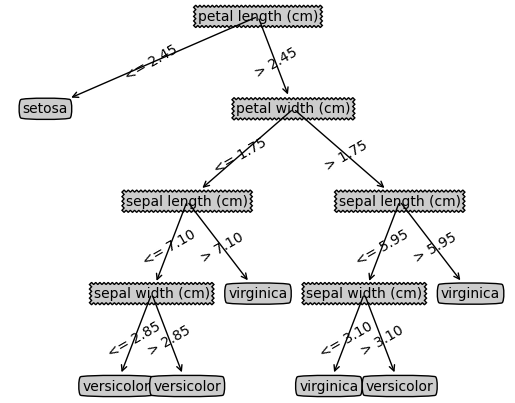

In [12]:
tpl.createPlot(decision_tree)

Function to classify an example using the decision tree :

In [13]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = float(testVec[featIndex])  # Convert the feature value to a floating-point number

    for branch in secondDict:
        if branch.startswith('<='):
            threshold = float(branch.split()[-1])  # Extract the threshold from the branch
            if key <= threshold:
                if isinstance(secondDict[branch], dict):
                    return classify(secondDict[branch], featLabels, testVec)
                else:
                    return secondDict[branch]
        elif branch.startswith('>'):
            threshold = float(branch.split()[-1])  # Extract the threshold from the branch
            if key > threshold:
                if isinstance(secondDict[branch], dict):
                    return classify(secondDict[branch], featLabels, testVec)
                else:
                    return secondDict[branch]
        else:
            # Discrete feature
            if key == float(branch):
                if isinstance(secondDict[branch], dict):
                    return classify(secondDict[branch], featLabels, testVec)
                else:
                    return secondDict[branch]

    # If none of the conditions are met, return a default value or raise an exception
    return "Unknown"  # You can replace "Unknown" with any default value or raise an exception if necessary

Example usage for the Iris dataset :

In [14]:
iris_instance = ['5.1', '3.5', '1.4', '0.2']  # Remplacer par les valeurs réelles des fonctionnalités
feature_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Print the predicted class

In [15]:
predicted_class = classify(decision_tree, feature_names, iris_instance)
print("Predicted Class:", predicted_class)

Predicted Class: setosa
